## Notebook looking at functional groups/pathways in A. thaliana

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from collections import defaultdict

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_stringdb_information
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_edgelist_doc2vec, pairwise_edgelist_bagofwords, pairwise_edgelist_setofwords
from oats.graphs.pairwise import pairwise_edgelist_annotations, merge_edgelists, subset_edgelist_with_ids
from oats.graphs.pairwise import remove_self_loops
from oats.objectives.functions import balance_classes
from oats.graphs.indexed import IndexedGraph

mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
# Reading in and generating orthologs dictionary from panther dataset for plant species.
# Need to figure out if reciprocals are given in this file.
df = pd.read_table("/Users/irbraun/Desktop/orthologs.txt")
df = df.head(100)
for row in df.itertuples():
    gene1_list = row[1].split("|")
    gene2_list = row[2].split("|")
    print(gene1_list)
    print(gene2_list)

    





['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['AMBTC', 'EnsemblGenome=AMTR_s00046p00227230', 'UniProtKB=U5CXP6']
['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['ZOSMR', 'Gene_ORFName=ZOSMA_39G00070', 'UniProtKB=A0A0K9P3W9']
['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['PHODC', 'Gene=LOC103712764', 'UniProtKB=A0A2H3YEN8']
['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['SETIT', 'EnsemblGenome=Si035784m.g', 'UniProtKB=K4AA78']
['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['SORBI', 'EnsemblGenome=SORBI_3010G157700', 'UniProtKB=C5Z408']
['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['SORBI', 'EnsemblGenome=SORBI_3007G027000', 'UniProtKB=A0A1B6PF58']
['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['MAIZE', 'EnsemblGenome=Zm00001d035185', 'UniProtKB=A0A1D6LEW9']
['CHLRE', 'Gene_ORFName=CHLRE_18g748397v5', 'UniProtKB=A0A2K3CNG5']
['ORYSJ',

### Reading in dataset and subsetting based on a functional group dataset

In [2]:
# Reading in the entire dataset, subsetting for Arabidosis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [3]:
# Subsetting the dataset to include only those genes that map to atleast one group from some classification source.
groups = load_from_pickle(path="../data/pickles/pmn_pathways.pickle")
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>1]    
dataset.filter_with_ids(group_mapped_ids)
#dataset.filter_random_k(40)
dataset.describe()


# What about subsetting for groups that have atleast two genes mapped to them?

Number of rows in the dataframe: 444
Number of unique IDs:            444
Number of unique descriptions:   394
Number of unique gene name sets: 444
Number of species represented:   1


In [4]:
# Get the mappings again now that the data has been subset.
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
sorted_group_tuples = sorted(group_id_to_ids.items(), key=lambda x: len(x[1]), reverse=True)
print("{:<20}{:<20}{:<20}".format("Num Genes Mapped","Pathway ID", "Pathway Name"))
for group in sorted_group_tuples[:10]:
    print("{:<20}{:<20}{:<20}".format(len(group_id_to_ids[group[0]]), group[0], groups.get_long_name(group[0]))) 

Num Genes Mapped    Pathway ID          Pathway Name        
21                  PWY66-399           gluconeogenesis III 
21                  GLUCONEO-PWY        gluconeogenesis I   
19                  PWY-6733            sporopollenin precursors biosynthesis
19                  PWY-6803            phosphatidylcholine acyl editing
18                  PWY-1121            suberin monomers biosynthesis
18                  PWY-361             phenylpropanoid biosynthesis
17                  GLYCOLYSIS          glycolysis I (from glucose 6-phosphate)
16                  PWY-5484            glycolysis II (from fructose 6-phosphate)
16                  PWY-581             indole-3-acetate biosynthesis II
15                  PWY-5971            palmitate biosynthesis II (bacteria and plants)


In [5]:
# Make a dictionary of descriptions with same quantity of words but randomly selected from the vocabulary.
from nltk.tokenize import word_tokenize
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
go_annotations = {k:[term for term in v if term[0:2]=="GO"] for k,v in annotations.items()}
po_annotations = {k:[term for term in v if term[0:2]=="PO"] for k,v in annotations.items()}
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#scrambled_descriptions = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

In [6]:
combined = {i:descriptions[i]+" "+" ".join(annotations[i]) for i in descriptions.keys()}

### Generating the edge list that specifies the graph constructed from text similarity

In [7]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()

# Generating the pairwise edgelist and saving it as a dataframe.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = pairwise_edgelist_bagofwords(descriptions) 
name_to_df_mapping["setofwords"] = pairwise_edgelist_setofwords(descriptions)
name_to_df_mapping["ontology"] = pairwise_edgelist_annotations(annotations, ontology)
#name_to_df_mapping["d2v_scrambled"] = pairwise_edgelist_doc2vec(doc2vec_model, scrambled_descriptions)
#name_to_df_mapping["bow_scrambled"] = pairwise_edgelist_bagofwords(scrambled_descriptions) 
#name_to_df_mapping["sow_scrambled"] = pairwise_edgelist_setofwords(scrambled_descriptions)
name_to_df_mapping["go"] = pairwise_edgelist_annotations(go_annotations, ontology)
name_to_df_mapping["po"] = pairwise_edgelist_annotations(po_annotations, ontology)


df = merge_edgelists(name_to_df_mapping, default_value=0.000)
df = remove_self_loops(df)
print(df.head(8))
print(df.shape[0])

   from  to   doc2vec  bagofwords  setofwords  ontology   go        po
1     1   9  0.508956    0.763184    0.963636  0.995556  1.0  1.000000
2     1  20  0.281114    0.734933    0.875000  0.937198  1.0  1.000000
3     1  23  0.228607    0.751529    0.875000  0.740741  1.0  0.000000
4     1  31  0.177779    0.617454    0.785714  0.917647  0.9  0.982456
5     1  32  0.201247    0.622242    0.800000  0.969512  1.0  1.000000
6     1  40  0.350276    0.811728    0.923077  0.993197  1.0  1.000000
7     1  44  0.520317    0.789153    0.960784  0.995349  1.0  1.000000
8     1  53  0.396525    0.928551    0.960000  0.976415  1.0  1.000000
98346


### Comparing baseline to within-group edge weight distributions

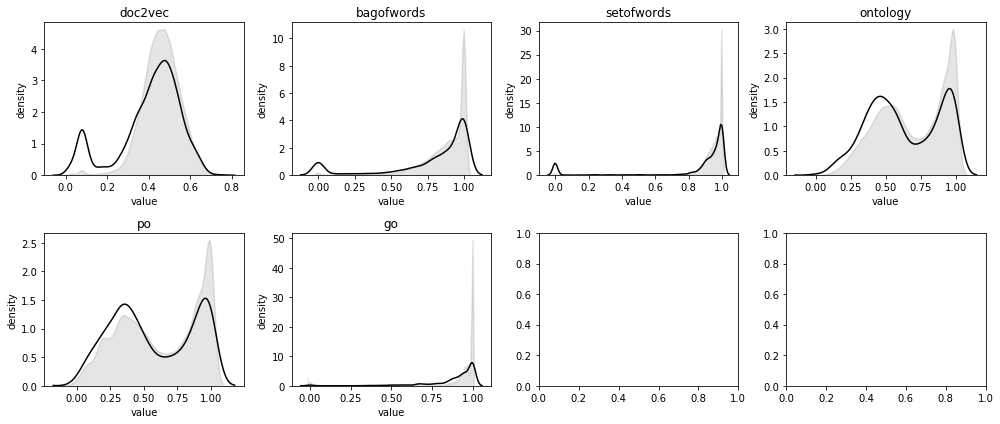

In [8]:
# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = ["doc2vec", "bagofwords", "setofwords", "ontology", "po", "go"]
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(list)
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method].extend(graph.get_values(within_pairs, kind=method))
        
# Plotting the kernel density estimates of the whole-data and within-group distributions.
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS,axs.flatten()):
    ax.set_title(method)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(within_weights_dict[method], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(all_weights_dict[method], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### Which biochemical pathways are the most 'phenotypically visible' in this dataset?

In [9]:
# Same thing but keeping track of means for each specific pathway or grouping with nested dict.

# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = ["doc2vec", "bagofwords", "setofwords", "ontology", "po", "go"]
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method][group] = np.mean((graph.get_values(within_pairs, kind=method)))

In [47]:
# Find the average rank of each pathway or group in terms of how low the mean within-group distance values were.
ranks = pd.DataFrame(within_weights_dict).rank()
ranks["average"] = ranks.mean(axis=1)
ranks.sort_values(by="average", inplace=True)


ranks.reset_index(inplace=True)
ranks["group_id"] = ranks["index"]
ranks["full_name"] = ranks["group_id"].apply(lambda x: groups.get_long_name(x))
ranks = ranks[["average","full_name"]]
print(ranks.head(10))



#means_df = pd.DataFrame(within_weights_dict)
#means_df.reset_index(inplace=True)
#means_df["name"] = means_df["index"].apply(lambda x: groups.get_long_name(x))

# need to add the values of n to this dataframe for each?




#means_df.sort_values(by=["doc2vec"], inplace=True)
#means_df["rank"] = means_df["doc2vec"].rank()
#print(means_df.head(20))









     average                                          full_name
0   4.833333                         L-asparagine degradation I
1   6.666667  UDP-&alpha;-D-galacturonate biosynthesis I (fr...
2   7.500000                          neurosporene biosynthesis
3  20.000000                                 UMP biosynthesis I
4  20.000000        L-arginine biosynthesis I (via L-ornithine)
5  28.833333                     caffeoylglucarate biosynthesis
6  29.833333                            zeaxanthin biosynthesis
7  29.833333                                lutein biosynthesis
8  30.666667                           L-histidine biosynthesis
9  32.500000  superpathway of carotenoid biosynthesis in plants


### Predicting whether two genes share or do not share a functional classification or pathway

In [11]:
# Generate the targe class values, 1 indicating common function and 0 indicating no common function.
df.loc[:,"class"] = [int(len(set(id_to_group_ids[id1]).intersection(set(id_to_group_ids[id2])))>0) 
    for (id1,id2) in zip(df["from"].values,df["to"].values)]
print(df.head(8))

   from  to   doc2vec  bagofwords  setofwords  ontology   go        po  class
1     1   9  0.508956    0.763184    0.963636  0.995556  1.0  1.000000      0
2     1  20  0.281114    0.734933    0.875000  0.937198  1.0  1.000000      0
3     1  23  0.228607    0.751529    0.875000  0.740741  1.0  0.000000      0
4     1  31  0.177779    0.617454    0.785714  0.917647  0.9  0.982456      1
5     1  32  0.201247    0.622242    0.800000  0.969512  1.0  1.000000      1
6     1  40  0.350276    0.811728    0.923077  0.993197  1.0  1.000000      0
7     1  44  0.520317    0.789153    0.960784  0.995349  1.0  1.000000      0
8     1  53  0.396525    0.928551    0.960000  0.976415  1.0  1.000000      0


               auc baseline n_shared  n_not
doc2vec     0.0542   0.0249     2451  95895
bagofwords  0.0639   0.0249     2451  95895
setofwords  0.0679   0.0249     2451  95895
ontology    0.0325   0.0249     2451  95895
po          0.0309   0.0249     2451  95895
go          0.0630   0.0249     2451  95895


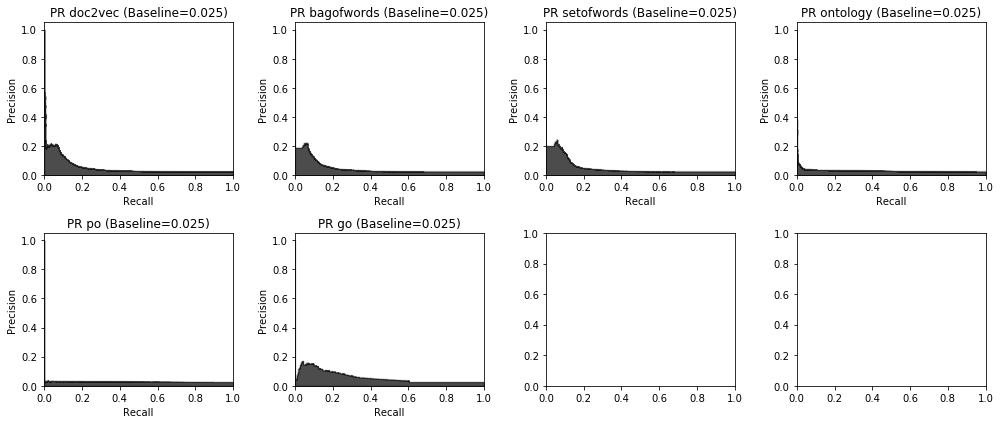

In [12]:
y_true_dict = {name:df["class"] for name in METHODS}
y_prob_dict = {name:(1 - df[name].values) for name in METHODS}
results = {}

num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS, axs.flatten()):
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[method] = {"auc":"{:.4f}".format(area), 
                       "baseline":"{:.4f}".format(baseline), 
                       "n_shared":"{:.0f}".format(n_pos), 
                       "n_not":"{:.0f}".format(n_neg)}
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
print(pd.DataFrame(results).transpose())
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### Predicting which functional group or pathway a specific gene belongs to

In [ ]:
# Can we learn associations between biochemical pathways and text descriptions?
# The non ml ways of doing this would be:
#    1 create a representative datapoint for each pathway by first dropping the specific sample then mapping.
#    need to implement a function for dropping k samples from the matrix calculation and then classifying them?
#    2 just use the mean similarity to other members of that thing.
#    3 The thing 